In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# We need to create a line for 3.7 and a sine wave for 3.8
# x is our input variable or feature
# t is our target variable or output

def generate_sine_data(n, noise=0.2):
    x = np.random.uniform(-1, 1, n) # same as before
    t = np.sin(2*np.pi*x) + np.random.normal(0, noise, n) # generates t values from a sine wave t = sin(2*pi*x)
    return x, t

In [29]:
def compute_kernel(xi, xj, lengthscale):
    # Assuming Gaussian kernel eq. 6.23
    return np.exp(-np.linalg.norm(xi - xj)**2 / (2 * lengthscale**2))

In [36]:
def gp_prediction(train_x, test_x, train_t):
    # equations 6.66 and 6.67

    # assuming our data noise = 0.2
    noise = 0.2 # variance
    lengthscale = 0.2 #this parameter controls how "similar" two inputs are 

    n = len(train_x)
    cov_matrix = np.empty((n+1,n+1))

    # Creating the C_N-1 Block
    for i in range(n):
        for j in range (i, n):
            cov_matrix[i, j] = compute_kernel(train_x[i], train_x[j], lengthscale)
            cov_matrix[j, i] = cov_matrix[i, j]
            if (i == j):
                cov_matrix[j,j] += noise # we add diagonal noise matrix since our assumption with y = f(x) + epsilon where epsilon follows a normal dist.

    # Creating the c "scalar"
    cov_matrix[n, n] = compute_kernel(test_x, test_x, lengthscale) + noise

    # Creating K-block
    for k in range(n):
        cov_matrix[n, k] = compute_kernel(test_x, train_x[k], lengthscale)
        cov_matrix[k, n] = cov_matrix[n, k] 

    k = cov_matrix[n, :n]  #1 x n-1 vector for k
    old_C = cov_matrix[:n, :n] #n-1 x n-1 cov matrix for old targets
    c = cov_matrix[n,n] # 1x1 scalar for c

    mean = k @ np.linalg.inv(old_C) @ train_t
    variance = c - k @ np.linalg.inv(old_C) @ np.transpose(k)  # variance, basically how uncertain we are about these predictions
    return mean, variance

In [39]:
def figure_3_8():
    x_data, t_data = generate_sine_data(25) # get 25 points from the t = sin(...) + noise
 
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()

    for idx, n in enumerate([2, 4, 8, 25]):
        train_x = x_data[:n-1]
        train_t = t_data[:n-1]
        test_x = x_data[n-1]
        
        x_plot = np.linspace(-1, 1, 200) # here we plot the 200 evenly spaced x values 
        means, stds = [], []
        
        #for each point in the plot, predict what the gp thinks the function looks like
        for new_x in x_plot:
            m_N, S_N = gp_prediction(train_x, new_x, train_t)
            # means is our "expected function" and  S_N is our model uncertainty with what the function looks like at a particular area each time randomly sample one new point
            means.append(m_N)
            # uncertainty for our expected function at certain points
            stds.append(S_N)
    
        means = np.array(means)
        stds = np.array(stds)
        
        # Plot true sine wave
        axes[idx].plot(x_plot, np.sin(2*np.pi*x_plot), 'g-', lw=2, label='True')

        #Plot posterior mean
        axes[idx].plot(x_plot, means, 'r-', lw=2, label='Mean')

        #Confidence bands
        axes[idx].fill_between(x_plot, means-stds, means+stds, color='r', alpha=0.2, label='±1 sigma')

        #Training points
        axes[idx].plot(x_data[:n-1], t_data[:n-1], 'bo', ms=8)
        axes[idx].set_xlim(-1, 1)
        axes[idx].set_ylim(-1.5, 1.5)
        axes[idx].set_title(f'N = {n}')
        axes[idx].set_xlabel('x')
        axes[idx].set_ylabel('t')
        if idx == 0:
            axes[idx].legend()

    plt.tight_layout()
    plt.show()

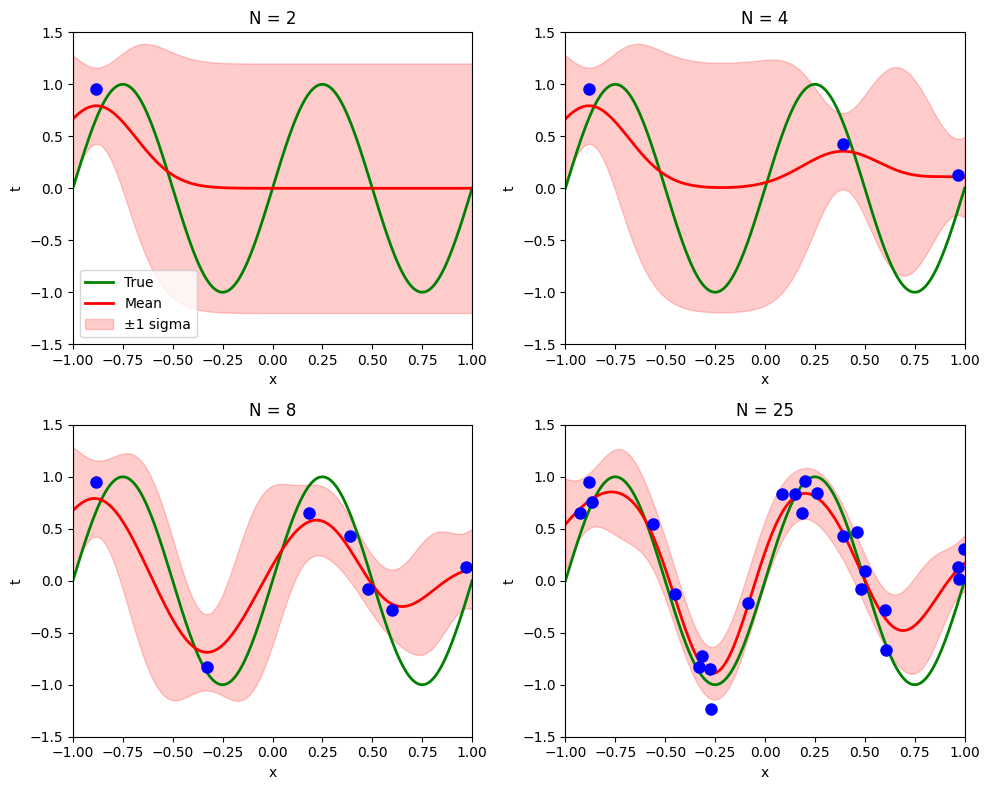

In [40]:
figure_3_8()